# Comparing rank aggregation algorithms with PyFLAGR

The fusion of multiple ranked lists of elements into a single aggregate list is a well-studied research field with numerous applications in Bioinformatics, recommendation systems, collaborative filtering, election systems and metasearch engines.

FLAGR is a high performance, modular, open source C++ library for rank aggregation problems. It implements baseline and recent state-of-the-art aggregation algorithms that accept multiple ranked preference lists and generate a single consensus list of elements. A portion of these methods apply exploratory analysis techniques and belong to the broad family of unsupervised learning techniques.



## Installation

PyFLAGR is a Python library built on top of FLAGR library core. It can be easily installed with pip:

``pip install pyflagr``

After installation, PyFLAGR can be used in standard Python programs and Jupyter notebooks. Representative code examples can be found on this notebook.


## Downloads, Documentation, Version and License

* The source code of FLAGR and PyFLAGR is available through the [official GitHub repository](https://github.com/lakritidis/FLAGR).
* The library is fully documented at [https://flagr.site/](https://flagr.site/).
* The current (Py)FLAGR version is 1.0.18.
* Both libraries are licensed under the [Apache License, version 2](http://www.apache.org/licenses/LICENSE-2.0).


## Importing and using PyFLAGR

PyFLAGR groups its supported rank aggregation methods in 6 modules:

1. `Linear`: This module contains the `CombSUM`, `CombMNZ`, `Borda` and `SimpleBorda` classes. `CombSUM` and `CombMNZ` support five normalization methods (see Renda et al., 2003). `Borda` and `SimpleBorda` are just wrappers of `CombSUM` with `borda` and `simple-borda` normalization.
2. `Majoritarian`: Includes:
    - `CondorcetWinners`,
    - `CopelandWinners` and
    - `OutrankingApproach` (Farah and Vanderpooten, 2007).
4. `MarkovChains`: Implements:
    - the four Markov Chains methods of Dwork et. al, 2001 and
    - the MCT variant of DeConde et al. 2006.
6. `Kemeny`: Includes `KemenyOptimal` (Kemeny Optimal Aggregation).
7. `RRA`: Includes `RobustRA` (Robust Rank Aggregation of Kolde et al., 2012 in two variants).
8. `Weighted`: This module implements several self-weighting rank aggregation methods. These methods automatically identify the expert voters and include:
    - The Preference Relations Graph method of Desarkar et al., 2016.
    - The Agglomerative method of Chatterjee et al., 2018.
    - The Iterative, Distance-Based method (DIBRA) of Akritidis et al., 2022.
 
The following statements demonstrate the imports of all PyFLAGR rank aggregation methods in a typical jupyter notebook.


In [1]:
# Import the PyFLAGR modules for rank aggregation
import pyflagr.Linear as Linear
import pyflagr.Majoritarian as Majoritarian
import pyflagr.MarkovChains as MarkovChains
import pyflagr.Kemeny as Kemeny
import pyflagr.RRA as RRA
import pyflagr.Weighted as Weighted
import pyflagr.Comparator as Comparator


## Input/Output files

A rank aggregation application involves a set of queries $Q=\{q_1,q_2,...,q_N\}$ and a set of rankers $R=\{r_1,r_2,...r_m\}$. Each query $q\in{Q}$ is submitted to all rankers in $R$, who respond by returning a ranked list of preference items sorted in decreasing importance, or relevance order. For example, in the context of recommendation systems, a set of users may be asked to enlist their preferences as a response to the hypothetical query "*which are your favorite games?*". Then, a rank aggregation algorithm must merge all the submitted preference lists, discover any important latent information, and generate a single output list with improved element ordering.

For the requirements of this notebook, we use a sample dataset that was created by employing [RASDaGen](https://github.com/lakritidis/RASDaGen), a synthetic dataset generator for rank aggregation applications. The dataset includes two files: `testdata.csv` and `testdata_qrels.csv`.

The former contains preference lists that were submitted by 50 voters for 20 queries. Each input list contains 30 elements. Therefore, the number of rows in this file is equal to $50 \times 20 \times 30=30000$. The columns of this CSV file must be organized in the following manner:

``Query, Voter Name, Item Code, Item Score, Algorithm/Dataset``

where
* `Query` represents the topic for which the preference list is submitted,
* `Voter` is the name of the ranker who submitted a preference list for a particular `Query`,
* `Item Code` is a unique name that identifies each element of the preference lists,
* `Item Score` is the preference score assigned to an item by a `Voter`, and
* `Algorithm/Dataset` is a user-defined string that represents the origin of a particular preference list.

The input csv file should not contain any headers. On the other hand, `testdata_qrels.csv` contains relevance judgments for the preference list elements of the primary input file for each query. It is organized in the following fashion:

``Query, 0, Item Code, Relevance``

where:
* `Query` represents the topic for which the preference list is submitted,
* `0`: unused. This value must be always 0.
* `Item Code` is a unique name that identifies each element of the preference lists,
* `Relevance` is nn integer value that represents the relevance of the item with respect to the mentioned `Query`. Typically, zero values represent irrelevant and incorrect elements; negative values represent spam elements; and positive values represent relevant, correct and informative elements.


Please refer to [this article](http://flagr.site/docs/38/input-and-output-files) for more details.


In [2]:
# The input data file with the input lists to be aggregated.
lists = '../testdata/testdata.csv'

# The input data file with the relevance judgements.
qrels = '../testdata/testdata_qrels.csv'


## The `Comparator` class

This notebook demonstrates the PyFLAGR's tools for testing and comparing rank aggregation methods. Code examples that show how each method can be individually executed and evaluated are presented in another notebook named `CodeExamples.ipynb`. Here we present the `Comparator` class and its member methods.

This class allows the researchers to perform head-to-head comparisons of the performance of various rank aggregation algorithms.


### Class constructor

The constructor receives a single argument that represents the cutoff point (termed *evaluation points*) at which the evaluation metrics will be computed. In the following example, we determine that the cutoff point is $10$, therefore, the following metrics will be computed:

* Mean Average Precision (MAP),
* Precision at points $1,2,...10$ (namely, $P@1,P@2,...P@N$),
* Recall at points $1,2,...10$ (namely, $R@1,R@2,...R@N$),
* Discounted Cumulative Gain, DCG (namely, $D@1,D@2,...D@N$), and
* normalized Discounted Cumulative Gain, nDCG (namely, $N@1,N@2,...N@N$).


In [3]:
EV_PTS = 10

cmp = Comparator.Comparator(EV_PTS)


### The `aggregators` array and the `add_aggregator` member function

The `Comparator` class contains an `aggregators` array that stores the rank aggregation methods to be compared. Each rank aggregation method is handled by an object that is passed to `Comparator` via the `add_aggregator` member function. 

Notice that the `eval_pts` parameter that is passed to each class constructor must be equal to the aforementioned value of the cutoff parameter. In the following example, we pass 21 rank aggregation methods to `Comparator`. This means that all these methods will be included in the evaluation tests.


In [4]:
cmp.add_aggregator("CombSUM-Rank", Linear.CombSUM(norm='rank', eval_pts=EV_PTS))
cmp.add_aggregator("CombSUM-Borda", Linear.CombSUM(norm='borda', eval_pts=EV_PTS))
cmp.add_aggregator("CombSUM-Score", Linear.CombSUM(norm='score', eval_pts=EV_PTS))
cmp.add_aggregator("CombMNZ-Rank", Linear.CombMNZ(norm='rank', eval_pts=EV_PTS))
cmp.add_aggregator("CombMNZ-Borda", Linear.CombMNZ(norm='borda', eval_pts=EV_PTS))
cmp.add_aggregator("CombMNZ-Score", Linear.CombMNZ(norm='score', eval_pts=EV_PTS))
cmp.add_aggregator("Condorcet", Majoritarian.CondorcetWinners(eval_pts=EV_PTS))
cmp.add_aggregator("Copeland", Majoritarian.CopelandWinners(eval_pts=EV_PTS))
cmp.add_aggregator("Outranking Approach", Majoritarian.OutrankingApproach(preference=0, veto=0.75, concordance=0,
                                                                          discordance=0.25, eval_pts=EV_PTS))
cmp.add_aggregator("MC1", MarkovChains.MC1(max_iterations=50, ergodic_number=0.15, eval_pts=EV_PTS))
cmp.add_aggregator("MC2", MarkovChains.MC2(max_iterations=50, ergodic_number=0.15, eval_pts=EV_PTS))
cmp.add_aggregator("MC3", MarkovChains.MC3(max_iterations=50, ergodic_number=0.15, eval_pts=EV_PTS))
cmp.add_aggregator("MC4", MarkovChains.MC4(max_iterations=50, ergodic_number=0.15, eval_pts=EV_PTS))
cmp.add_aggregator("MCT", MarkovChains.MCT(max_iterations=50, ergodic_number=0.15, eval_pts=EV_PTS))
cmp.add_aggregator("RRA-Exact", RRA.RRA(exact=True, eval_pts=EV_PTS))
cmp.add_aggregator("RRA", RRA.RRA(exact=False, eval_pts=EV_PTS))
cmp.add_aggregator("PrefRel", Weighted.PreferenceRelationsGraph(alpha=0.1, beta=0.5, eval_pts=EV_PTS))
cmp.add_aggregator("Agglomerative", Weighted.Agglomerative(c1=0.1, c2=0.2, eval_pts=EV_PTS))
cmp.add_aggregator("DIBRA", Weighted.DIBRA(aggregator='combsum:borda', gamma=1.2, prune=None, w_norm='minmax',
                                           eval_pts=EV_PTS))
cmp.add_aggregator("DIBRA-Prune", Weighted.DIBRA(aggregator='combsum:borda', gamma=1.2, prune='low', w_norm='minmax',
                                                 d1=0.3, d2=0.05, eval_pts=EV_PTS))
cmp.add_aggregator("DIBRA-Prune-WISE", Weighted.DIBRA(aggregator='combsum:borda', gamma=1.2, prune='wire', w_norm='minmax',
                                                 num_buckets=5, d1=0.5, d2=1.0, eval_pts=EV_PTS))

### The `aggregate()` member function

After the `Comparator` class has been initialized and the algorithms to be evaluated have been determined, the `aggregate()` member function must be called to start the evaluation process. The `aggregate()` method accepts the two following arguments:

* The input data file that contains the preference lists to be aggregated (in our case `testdata.csv`), and
* The Rels file that contains relevance judgments for the elements of the preference lists (in our case `testdata_qrels.csv`). This is the ground truth file that will be used to evaluate the generated aggregate lists.

Again, please refer to [this article](http://flagr.site/docs/38/input-and-output-files) for a detailed description of the format of the input and output files.


In [5]:
cmp.aggregate(input_file=lists, rels_file=qrels)


Running CombSUM-Rank ...
Running CombSUM-Borda ...
Running CombSUM-Score ...
Running CombMNZ-Rank ...
Running CombMNZ-Borda ...
Running CombMNZ-Score ...
Running Condorcet ...
Running Copeland ...
Running Outranking Approach ...
Running MC1 ...
Running MC2 ...
Running MC3 ...
Running MC4 ...
Running MCT ...
Running RRA-Exact ...
Running RRA ...
Running PrefRel ...
Running Agglomerative ...
Running DIBRA ...
Running DIBRA-Prune ...
Running DIBRA-Prune-WISE ...


### The `results` Dataframe

The evaluation results are stored in the `results` member of `Comparator`. Each row in this Dataframe represents the performance of an algorithm for a particular query. There is also one additional row per method, that records its average performance for all queries. In this example, we have $21$ rank aggregation methods and $20$ queries, consequently, the `results` Dataframe contains $21 \cdot (20+1) = 441$ rows.

The number of columns in the `results` Dataframe depends on the value of the cutoff point that we set during the construction of `Comparator`. In this example this value is $10$, so the Dataframe has $46$ columns:
* 1 column that represents the query string,
* 1 column that represents the length (i.e. the number of elements in the) aggregate list,
* 1 column for the total number of relevant elements for this query,
* 1 column for the number of relevant elements included in the aggregate list,
* 1 column for the Average Precision of a method for this query,
* 10 columns for Precision (at 10 points in the aggregate list),
* 10 columns for Recall (at 10 points in the aggregate list),
* 10 columns for DCG (at 10 points in the aggregate list),
* 10 columns for nDCG (at 10 points in the aggregate list),
* 1 column for the method's name.

Brief descriptions of the aforementioned evaluation measures are provided in the Appendix at the end of this notebook.


In [6]:
cmp.results


,q,num_ret,num_rel,num_rel_ret,Mean Average Precision (MAP),P_1,P_2,P_3,P_4,P_5,...,ndcg_cut_2,ndcg_cut_3,ndcg_cut_4,ndcg_cut_5,ndcg_cut_6,ndcg_cut_7,ndcg_cut_8,ndcg_cut_9,ndcg_cut_10,Method
0,Topic 1,100,48,48,0.534255,1.00,1.0,0.666667,0.50,0.40,...,1.000000,0.765361,0.636682,0.553146,0.493523,0.539929,0.496846,0.532447,0.498572,CombSUM-Rank
1,Topic 2,100,46,46,0.539673,0.00,0.5,0.666667,0.50,0.40,...,0.386853,0.530721,0.441492,0.383566,0.450011,0.500404,0.540269,0.572798,0.536356,CombSUM-Rank
2,Topic 3,100,40,40,0.442181,1.00,1.0,0.666667,0.50,0.40,...,1.000000,0.765361,0.636682,0.553146,0.493523,0.448304,0.492326,0.528247,0.558260,CombSUM-Rank
3,Topic 4,100,40,40,0.427771,0.00,0.0,0.000000,0.25,0.20,...,0.000000,0.000000,0.168128,0.146068,0.130324,0.210008,0.273045,0.253726,0.301204,CombSUM-Rank
4,Topic 5,100,54,54,0.656236,1.00,1.0,1.000000,1.00,1.00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.920205,0.855096,0.864315,CombSUM-Rank
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,Topic 17,99,48,47,0.598559,1.00,1.0,0.666667,0.50,0.60,...,1.000000,0.765361,0.636682,0.684352,0.718375,0.744179,0.684798,0.707100,0.662114,DIBRA-Prune-WISE
17,Topic 18,100,39,39,0.507380,1.00,1.0,0.666667,0.75,0.80,...,1.000000,0.765361,0.804810,0.830420,0.848699,0.770936,0.709420,0.659224,0.617284,DIBRA-Prune-WISE
18,Topic 19,100,45,45,0.461626,1.00,1.0,1.000000,1.00,0.80,...,1.000000,1.000000,1.000000,0.868795,0.775148,0.704125,0.727734,0.676243,0.633220,DIBRA-Prune-WISE
19,Topic 20,100,45,45,0.533849,1.00,1.0,1.000000,1.00,0.80,...,1.000000,1.000000,1.000000,0.868795,0.775148,0.704125,0.647940,0.602094,0.563788,DIBRA-Prune-WISE


### Retrieving the evaluation results with `get_results()`

The `get_results()` method can be used to easily retrieve slices of the `results` Dataframe. In the following example, we get the mean values of MAP, Precision and nDCG for all queries, and for each method.


In [7]:
df = cmp.get_results(cutoff=5, metric=["map", "precision", "ndcg"], query='all')

print(df.shape)
df.style.format(precision=4)


(21, 11)


,Mean Average Precision (MAP),P_1,P_2,P_3,P_4,P_5,ndcg_cut_1,ndcg_cut_2,ndcg_cut_3,ndcg_cut_4,ndcg_cut_5
Method,,,,,,,,,,,
CombSUM-Rank,0.4855,0.4500,0.4750,0.4167,0.4500,0.4400,0.4500,0.4693,0.4296,0.4498,0.4433
CombSUM-Borda,0.4836,0.5000,0.4750,0.4167,0.4250,0.4200,0.5000,0.4807,0.4383,0.4402,0.4350
CombSUM-Score,0.4854,0.4000,0.4750,0.4500,0.4625,0.4400,0.4000,0.4580,0.4444,0.4538,0.4401
CombMNZ-Rank,0.4853,0.5000,0.5000,0.4167,0.4375,0.4100,0.5000,0.5000,0.4413,0.4512,0.4314
CombMNZ-Borda,0.4849,0.5500,0.4500,0.4833,0.5000,0.4700,0.5500,0.4726,0.4908,0.5007,0.4810
CombMNZ-Score,0.4848,0.5000,0.5000,0.4167,0.4375,0.4100,0.5000,0.5000,0.4413,0.4512,0.4314
Condorcet,0.4801,0.5000,0.4750,0.4333,0.4125,0.4300,0.5000,0.4807,0.4500,0.4332,0.4420
Copeland,0.4820,0.5000,0.4500,0.4167,0.4000,0.4100,0.5000,0.4613,0.4352,0.4209,0.4247
Outranking Approach,0.4817,0.5000,0.4250,0.4333,0.4125,0.4400,0.5000,0.4420,0.4439,0.4281,0.4441


### Converting to LaTeX

The `convert_to_latex()` method can be used to convert the acquired results to a LaTeX tabular construct:


In [8]:
latex_code = cmp.convert_to_latex(dec_pts=4, cutoff=EV_PTS, metric=["map", "precision", "ndcg"], query='all')
# print(latex_code)


C:\Users\Leo\anaconda3\lib\site-packages\pyflagr\Comparator.py:118: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.get_results(cutoff, metric, query).round(dec_pts).to_latex()


### Plots: Mean Average Precision

There are two types of plots in `Comparator`. The first one creates a bar plot of the Mean Average Precision of all methods:

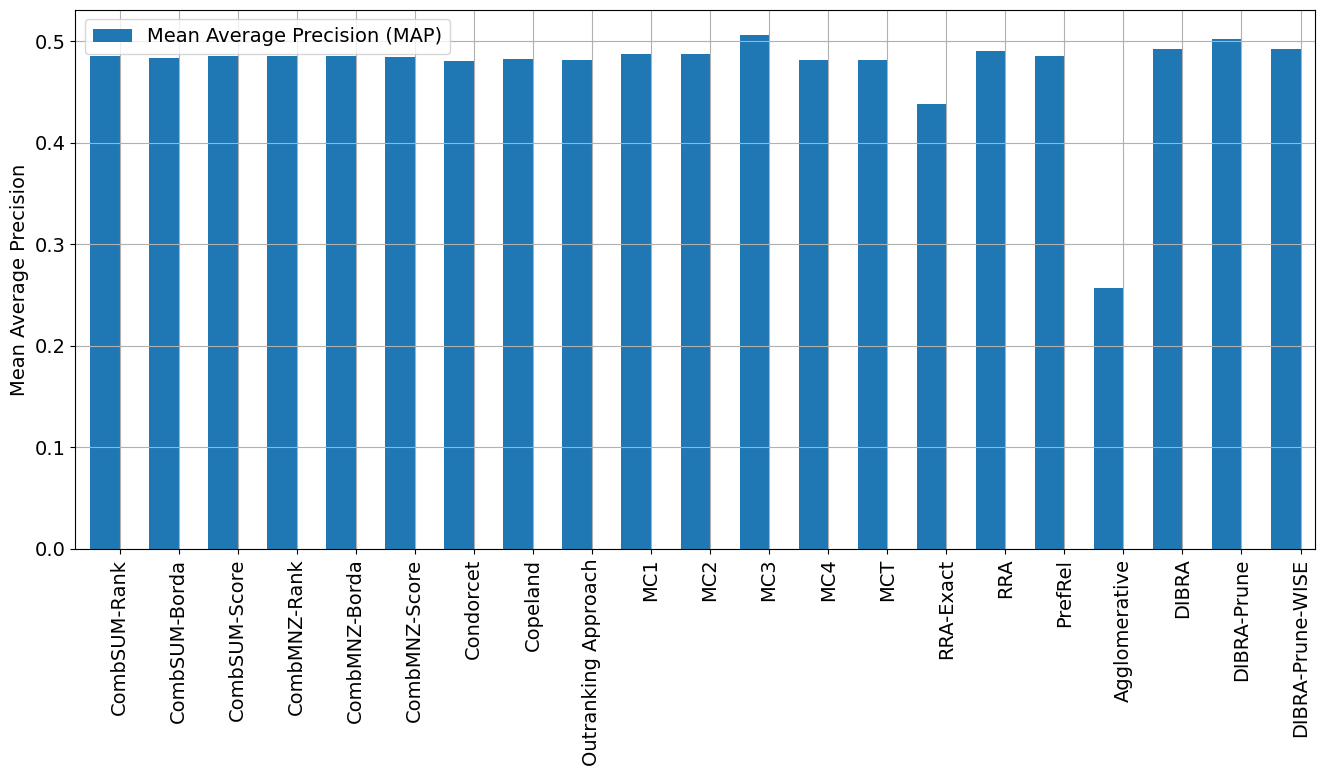

In [9]:
cmp.plot_average_precision((16, 7), True, query='all')


### Plots: Evaluation measures at specific cutoff points

The `plot_metric()` method produces plots of the values of a particular evaluation metric at specific cutoff points of the aggregate list. The argument `metric` determines the metric to be plotted; it may receive one of the following values:
* `precision`
* `recall`
* `dcg`
* `ndcg`


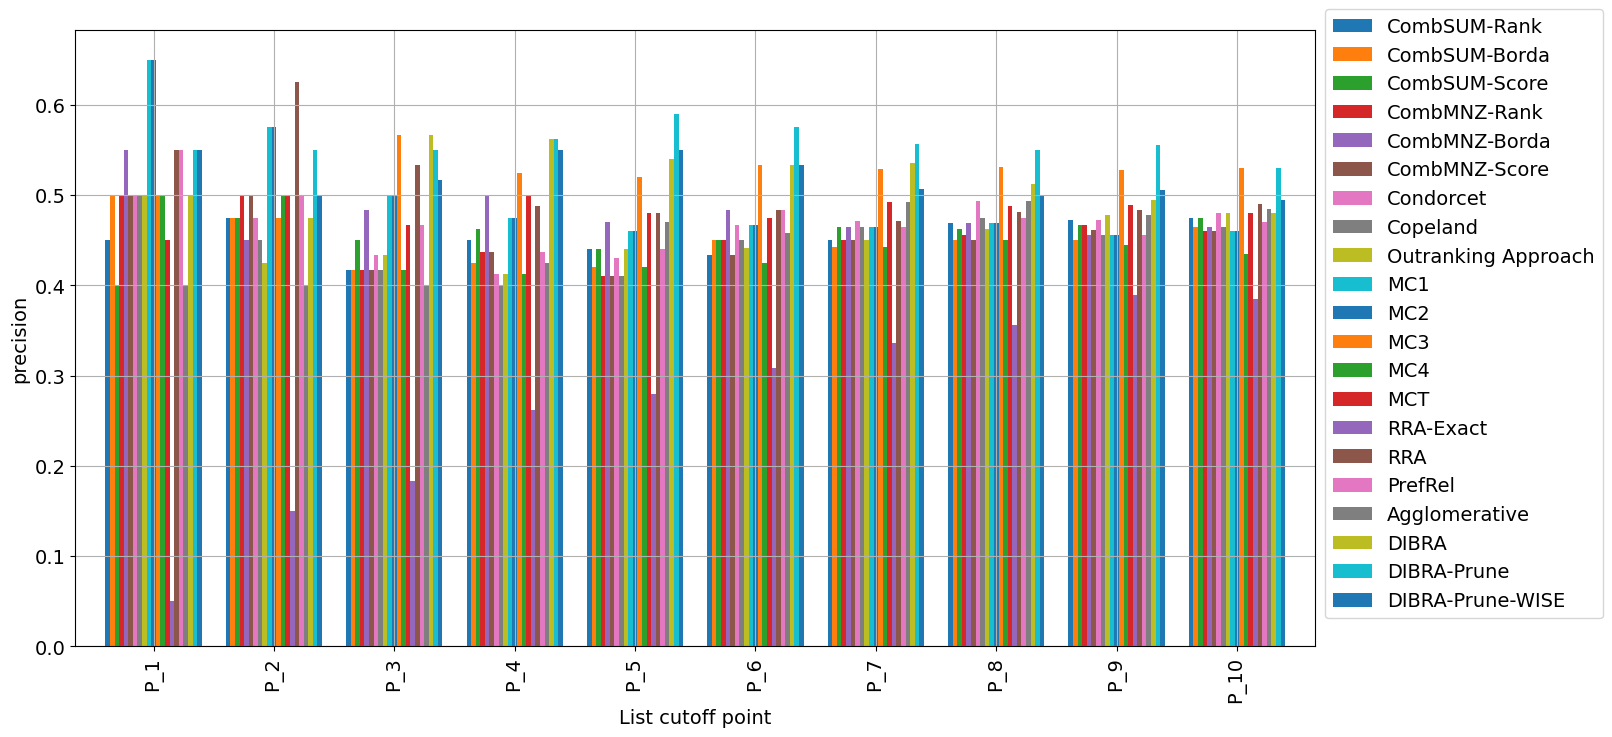

In [10]:
cmp.plot_metric(EV_PTS, metric='precision', plot_type='bar', dimensions=(16,8), show_grid=True, query='all')


The `plot_type` parameter can be either `bar`, or `line`:

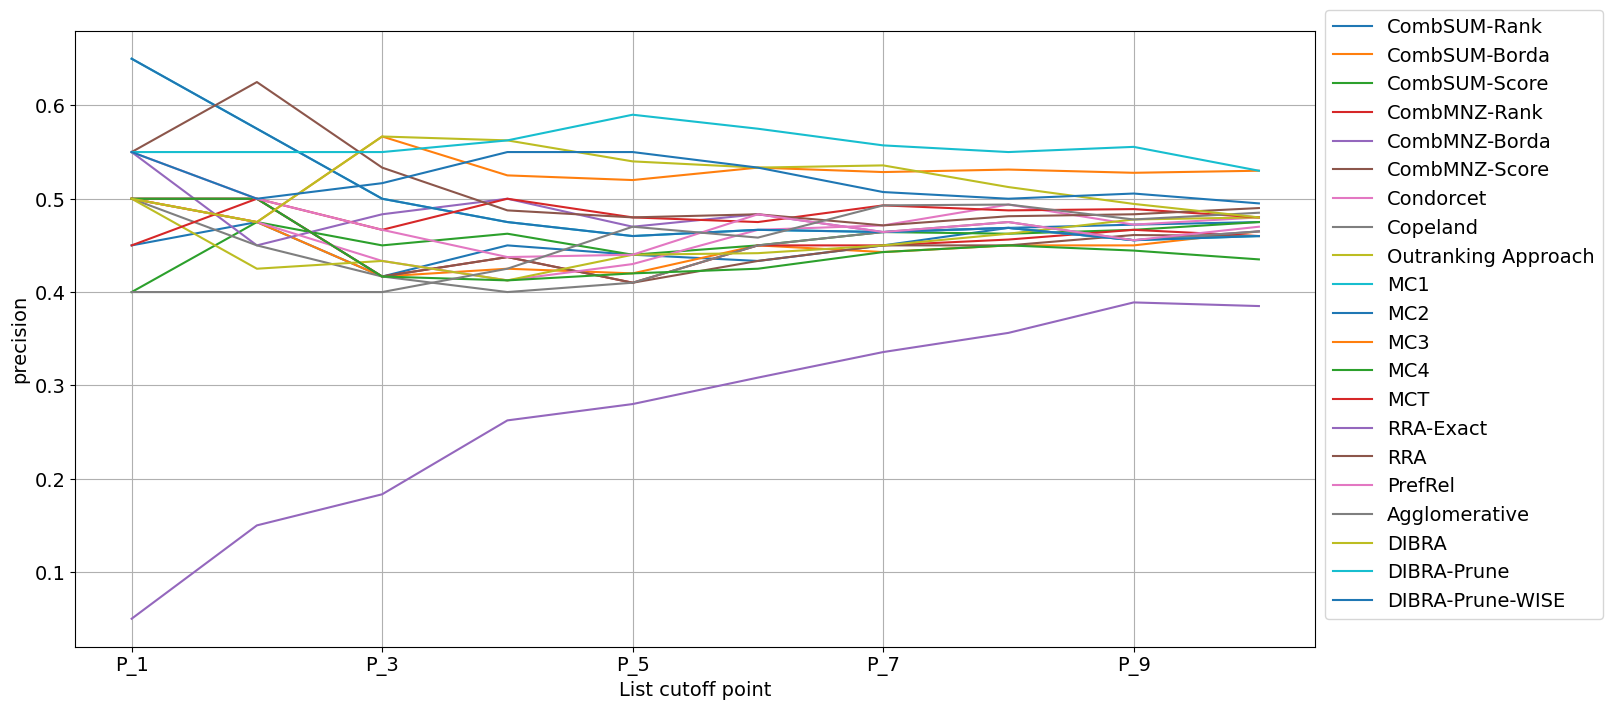

In [11]:
cmp.plot_metric(EV_PTS, metric='precision', plot_type='line', dimensions=(16,8), show_grid=True, query='all')


## Appendix: Evaluation measures

### $\text{Precision@}k$

Precision measures the ability of an algorithm to precisely detect the relevant elements. It is defined as the ratio of the number of relevant elements at the $k$-th element of a list, divided by the number of **retrieved** elements (i.e. $k$}:

$$\text{Precision@}k=\frac{\text{true positives}@k}{(\text{true positives}@k) + (\text{false positives}@k)}$$

### $\text{Recall@}k$

Recall measures the ability of an algorithm to detect the relevant elements early. It is defined as the ratio of the number of relevant elements at the $k$-th element of a list, divided by the number of **all relevant** elements:

$$\text{Recall@}k=\frac{\text{true positives}@k}{(\text{true positives}@k) + (\text{false negatives}@k)}$$

### $F1@k$

$F1$ is a well-established measure that combines Precision and Recall into a single scoring formula:

$$F1@k=\frac{2 \cdot \text{Precision@}k \cdot \text{Recall@}k }{\text{Precision@}k + \text{Recall@}k}$$


### Discounted Cumulative Gain ($DCG@k$)

$DCG$ is another measure for evaluating the performance of an algorithm. In contrast to the previous measures, this one can handle non-binary relevance judgments. In other words, the relevance score of an item may be a real value, and not just a relevant/non-relevant label. It is defined by the following formula:

$$DCG@k=\sum_{i=1}^{k}\frac{2^{ {rel}_i } - 1}{\log_2(i + 1)}$$

where ${rel}_i$ is the relevance score of the element at index $i$. For binary problems, we set ${rel}_i=1$ if the $i$-th list element is relevant and 0 otherwise.


### Normalized Discounted Cumulative Gain ($nDCG@k$)

One disadvantage of $DCG$ is that it is non-decreasing; it either stays the same (if the current element is non-relevant), or it increases (if the current element is relevant). This means that queries that return larger result sets will probably always have higher DCG scores than queries that return small result sets.

The Normalized Discounted Cumulative Gain ($nDCG$) confronts this problem by dividing $DCG$ with the maximum possible DCG at each threshold $k$:

$$nDCG@k=\frac{DCG@k}{IDCG@k}$$

where $IDCG@k$ is the *Ideal* $DCG@k$. To compute it, we first create an ideal ranking, where the elements are ranked in decreasing relevance order. Then, $IDCG@k$ is simply equal to $DCG@k$ in that ideal ranking, namely:

$$IDCG@k=\sum_{i=1}^{\text{relevant items @}k}\frac{2^{ {rel}_i } - 1}{\log_2(i + 1)}$$


### Average Precision ($AP$)

AP is another evaluation metric that quantifies the ability of an algorithm to rank the relevant elements in the highest list positions. It is defined by the following equation:

$$AP=\sum_{k}(\text{Recall@}k-\text{Recall@}k-1)\cdot\text{Precision@}k$$


### Mean Average Precision (MAP)

Average Precision ($AP$) quantifies the quality of a **single** ranked list compared with the ground truth. In other words, $AP$ examines a **single ranking** that is generated in response to a **single** query.

In contrast, Mean Average Precision evaluates a ranking model for a **set** of queries $Q$. MAP is simply defined as the mean of the Average Precisions over **all** queries. Consequently, its computation is performed by firstly summing up the $AP_q$ value for each query $q$ in the dataset and then, the sum is divided by the number of queries.

$$MAP=\frac{1}{|Q|}\sum_{q=1}^{|Q|}{AP}_q$$


### Example

Consider a ranked list including 8 elements that has been submitted as a response to a query. From these elements, the 1st, 3rd, 4th, and 6th are relevant to the query. The rest of the elements are considered as not relevant. The first two columns of the following table show the list and the relevance of its elements. The rest of the columns contain the running values of Precision, Recall, $F1$, $DCG$, $IDCG$, $nDCG$ and Average Precision ($AP$) at each list element.

| Rank | Relevant | $\text{Precision}@k$ | $\text{Recall}@k$ | $F1@k$ | $DCG@k$ | $IDCG@k$ | $nDCG@k$ | $AP@k$ |
| :--: | :------: | :------------------: | :---------------: | :----: | :-----: | :------: | :------: | :----: |
| 1    | **Yes**  |      $1.00$          |       $0.25$      | $0.40$ |  $1.00$ |  $1.00$  |  $1.00$  | $1.00$ |
| 2    |    No    |      $0.50$          |       $0.25$      | $0.33$ |  $1.00$ |  $1.63$  |  $0.61$  | $1.00$ |
| 3    | **Yes**  |      $0.67$          |       $0.50$      | $0.62$ |  $1.50$ |  $2.13$  |  $0.70$  | $0.83$ |
| 4    | **Yes**  |      $0.75$          |       $0.75$      | $0.75$ |  $1.93$ |  $2.56$  |  $0.75$  | $0.81$ |
| 5    |    No    |      $0.60$          |       $0.75$      | $0.66$ |  $1.93$ |  $2.56$  |  $0.75$  | $0.81$ |
| 6    | **Yes**  |      $0.67$          |       $1.00$      | $0.80$ |  $2.29$ |  $2.56$  |  $0.89$  | $0.77$ |
| 7    |    No    |      $0.57$          |       $1.00$      | $0.73$ |  $2.29$ |  $2.56$  |  $0.89$  | $0.77$ |
| 8    |    No    |      $0.50$          |       $1.00$      | $0.66$ |  $2.29$ |  $2.56$  |  $0.89$  | $0.77$ |


#### Example calculations at the 5th element of the list (@5)

According to the aforementioned definitions, the following calculations are performed:

$$\text{Precision@}5=\frac{\text{relevant elements found up to position 5}}{\text{retrieved elements up to position 5}}=\frac{3}{5}=0.60$$

$$\text{Precision@}5=\frac{\text{relevant elements found up to position 5}}{\text{all relevant elements}}=\frac{3}{4}=0.75$$

$$F1@5=\frac{2 \cdot \text{Precision@}5 \cdot \text{Recall@}5 }{\text{Precision@}5 + \text{Recall@}5}=\frac{2 \cdot 0.60 \cdot 0.75}{0.60+0.75}=0.67$$

$$DCG@5=\frac{2^1 - 1}{\log_2(1 + 1)}+\frac{2^0 - 1}{\log_2(2 + 1)}+\frac{2^1 - 1}{\log_2(3 + 1)}+\frac{2^1 - 1}{\log_2(4 + 1)}++\frac{2^{ 0 } - 1}{\log_2(5 + 1)}=1.93$$

$$IDCG@5=\frac{2^1 - 1}{\log_2(1 + 1)}+\frac{2^1 - 1}{\log_2(2 + 1)}+\frac{2^1 - 1}{\log_2(3 + 1)}+\frac{2^1 - 1}{\log_2(4 + 1)}++\frac{2^{ 0 } - 1}{\log_2(5 + 1)}=2.56$$

$$nDCG@5=\frac{DCG@5}{IDCG@5}=\frac{1.93}{2.56}=0.75$$

$$AP@5=\frac{1+0.67+0.75}{3}=0.81$$
